# Calcul de la constante de Lifschitz sans entrainement

In [8]:
# importation
import numpy as np
from torch.autograd import Variable
import torch
import matplotlib.pyplot as plt
%matplotlib inline
# local
from FBResNet.myfunc import Physics
from FBResNet.myfunc import MyMatmul
from FBResNet.main import FBRestNet
from FBResNet.model import MyModel
from FBResNet.posttreat import Export_hyper

### Parametres

In [9]:
exp1 = FBRestNet(experimentation=Physics(2000,500,1,1), nb_blocks=20, noise = 0.1,\
                 folder = './', im_set="Set1",batch_size=[600,1],\
                 lr=1e-3, nb_epochs=[30,1])

### Data set
On entraine sur 300 données et on évalue sur 100.

In [10]:
train_set, val_set = exp1.CreateDataSet()

### Trainings
Entrainement sur 20 époques, learning rate de $10^{-3}$.
On trace la constante de Lipschitz au cours de l' entrainement.

In [7]:
#exp1.train(train_set,val_set,save_model=True)

epoch :  0  -----  validation :  7.943260446716604e-05
epoch :  1  -----  validation :  8.025704053707798e-05
epoch :  2  -----  validation :  8.103680585150667e-05
epoch :  3  -----  validation :  8.17469043882263e-05
epoch :  4  -----  validation :  8.23973292499797e-05
epoch :  5  -----  validation :  8.296301874810954e-05
epoch :  6  -----  validation :  8.352129731321299e-05


KeyboardInterrupt: 

### Affichage de résultats

In [ ]:
l_i, l_t, l_p = exp1.test(val_set)

### Affichage paramètres

In [ ]:
gamma =np.zeros(20)
reg   =np.zeros(20)
mu    =np.zeros(20)
for i in range(0,len(exp1.model.Layers)):
    gamma[i] = exp1.model.Layers[i].gamma_reg[0]
    reg[i]   = exp1.model.Layers[i].gamma_reg[1]
    mu[i]    = exp1.model.Layers[i].mu[0]

In [ ]:
k = np.linspace(1,20,20)

In [ ]:
plt.plot(k,gamma)

In [ ]:
plt.plot(k,reg)

In [ ]:
plt.plot(k,mu)

In [ ]:
# Gaussienne 
exp   = Physics(2000,50,1,1)
t     = np.linspace(0,1,2000)
gauss = np.exp((t-0.5)**2/(0.1)**(2))
gauss = np.sqrt(2000)*gauss/np.linalg.norm(gauss)
noise = 0.1*np.random.randn(2000)
x_b   = exp.ComputeAdjoint(exp.Compute(gauss)+noise).reshape(1,1,50)
# passage float tensor
x_bias    = Variable(torch.FloatTensor(x_b),requires_grad=False)
# definition of the initialisation tensor
x_init   = torch.zeros(x_bias.size())
tDD      = MyMatmul(exp1.physics.Operators()[0])
x_init[:,:,:25] = tDD(x_bias)[:,:,:25]
x_init   = Variable(x_init,requires_grad=False)

In [ ]:
folder = './Redaction/data'
Export_hyper(exp1,x_init,x_b,folder)

### REG Parameter

In [ ]:
from torch.autograd import Variable
minibatch = iter(val_set)
[y, x] = next(minibatch)            # gets the minibatch
x_true = Variable(x,requires_grad=False)
x_bias = Variable(y,requires_grad=False)

In [ ]:
from FBResNet.model import Cnn_reg

In [ ]:
exp=Physics(2000,50,1,1)
mycnn = Cnn_reg(exp)

In [ ]:
mycnn(x_bias)

### Test with gaussian

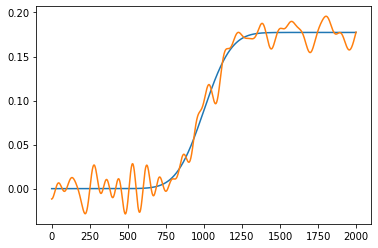

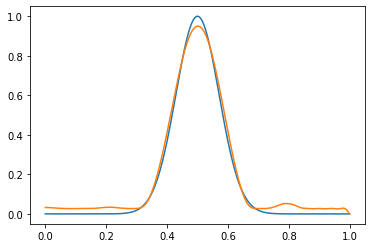

In [11]:
exp1.test_gauss()

In [12]:
x_bias.shape

NameError: name 'x_bias' is not defined

In [ ]:
# Gaussienne 
nx    = exp1.physics.nx
m     = exp1.physics.m
t     = np.linspace(0,1,nx)
gauss = np.exp((t-0.5)**2/(0.1)**(2))
gauss = np.sqrt(nx)*gauss/np.linalg.norm(gauss)
noise = 0.01*np.random.randn(nx)
x_b   = exp1.physics.ComputeAdjoint(exp1.physics.Compute(gauss)+noise).reshape(1,1,m)
print("x/xb =",np.linalg.norm(x_b)/(1/np.sqrt(nx)*np.linalg.norm(gauss)))

In [ ]:
def test_gauss(self):
    # Gaussienne 
    nx    = self.physics.nx
    m     = self.physics.m
    t     = np.linspace(0,1,nx)
    gauss = np.exp(-(t-0.5)**2/(0.1)**(2))
    #gauss = np.sqrt(nx)*gauss/np.linalg.norm(gauss)
    gauss = gauss/np.amax(gauss)
    # export
    Export_Data(t,gauss,'./Redaction/data','gauss')
    #
    noise = 0.01*np.random.randn(nx)
    x_b   = self.physics.ComputeAdjoint(self.physics.Compute(gauss)+noise)
    plt.plot(self.physics.Compute(gauss)+noise)
    plt.show()
    # passage float tensor
    x_bias    = Variable(torch.FloatTensor(x_b.reshape(1,1,-1)),requires_grad=False)
    # definition of the initialisation tensor
    x_init   = torch.zeros(x_bias.shape)
    tTTinv   = MyMatmul(np.diag(self.physics.eigm**(2*self.physics.a)))
    print(x_init.shape)
    print(x_bias.shape)
    print(tTTinv(x_bias).shape)
    x_init[:,:,:30] = tTTinv(x_bias)[:,:,:30] # filtration of high frequences
    x_init   = Variable(x_init.reshape(1,1,-1),requires_grad=False)
    # prediction
    x_pred   = self.model(x_init,x_bias)
    xpc      = x_pred.detach().numpy()[0,0,:]
    xp       = self.physics.BasisChangeInv(xpc)
    print(t.shape)
    # export
    Export_Data(t,xp,'./Redaction/data','gauss_pred_a{}_'.format(self.physics.a)+self.constr)
    # plot
    plt.plot(t,gauss)
    plt.plot(t,xp)
    #
    print("x/xb =",np.linalg.norm(x_b)/(1/np.sqrt(nx)*np.linalg.norm(gauss)))

In [13]:
from FBResNet.posttreat import Export_Data
test_gauss(exp1)

NameError: name 'test_gauss' is not defined

In [14]:
exp1.model.Lipschitz(opt1="semi",opt2="entree11")

0.049292317194403745

In [15]:
exp1.model.Lipschitz(opt1="semi",opt2="entree01")

2.824654153318768e-05